In [9]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import glob 
import os
import warnings
import networkx as nx
import matplotlib.colors as mcolors
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import pearsonr
from sklearn.covariance import GraphicalLassoCV
from networkx.generators.community import gaussian_random_partition_graph
import scipy.stats as stats
from scipy.stats import ttest_ind
import nibabel as nib 

In [10]:
#start with formattting data, getting master csv of all patients regional volume 
#create master csv file with all vol for each region for each patient
#cols would be 'id','001','002'....
#rows would be id numbers 0173

dir = "/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi"
data_dic = {}
patient_data = {}
#iterate through patient folders to extract the values of the .npy files 
for folder in sorted(glob.glob(os.path.join(dir,"wneuromorphometrics_*"))):
    # print(f"processing: {folder}")
    id = folder[-4:]
    volumes = []
    #data dicitonary to store corresponding labels and values 
    for file in sorted(glob.glob(os.path.join(folder, "*.npy"))): #search for all .npy files 
        reg_num = os.path.splitext(os.path.basename(file))[0] #os.path.basename returns filename itself with extension
        #os.path.splittext()[0] splits file basename into a tuple of file name string and the extension (001,.npy) [0] tells it to extract first el of this tuple (001)
        # print(reg_num)
        node_data = np.load(file)
        # print(reg_num, node_data)
        data_dic[reg_num]=node_data
        volumes.append(node_data)

    patient_data[id]=volumes

patient_ids = list(patient_data.keys())

progs_norm = pd.DataFrame.from_dict(patient_data,orient='index')
progs_norm.columns = [str(int(col) + 1) for col in progs_norm.columns]
progs_norm['id'] = patient_ids
progs_norm.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/mega_csv.csv')
print(progs_norm.shape)
print(progs_norm)

(545, 143)
            1    2    3    4    5    6    7    8     9    10  ...    134  \
0173  1461786  118  285  303  150  150  350  352  5258  6796  ...  11021   
0307  1460313  117  285  302  149  154  347  354  5277  6769  ...  11041   
0331  1459847  119  285  303  147  153  349  354  5277  6786  ...  11009   
0376  1461197  120  284  302  149  138  349  354  5261  6758  ...  11035   
0388  1462081  121  285  302  149  151  348  355  5289  6766  ...  11023   
...       ...  ...  ...  ...  ...  ...  ...  ...   ...   ...  ...    ...   
6627  1461387  117  285  303  149  154  349  355  5272  6797  ...  10983   
6632  1459008  119  285  302  152  155  350  355  5279  6850  ...  11093   
6635  1456677  111  275  300  148  153  349  347  5283  6838  ...  11038   
6652  1458206  119  283  301  151  152  352  354  5274  6808  ...  11087   
6668  1458654  115  282  301  147  153  351  352  5303  6825  ...  11062   

       135   136   137   138   139   140   141   142    id  
0173  5701  635

In [11]:
#add in progression info and then split dataframes into stable and progressive mci 
prog_info = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/ADNI_surv_prog.csv")
# all_df = pd.read_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/hip_weights.csv") #doesn't work if I just read it in as a csv weird 

prog = prog_info[['RID',"PROGRESSES"]]
#add in padded zeros to prog df 
prog['RID']=prog["RID"].astype(str).str.zfill(4)

#filter prog to only include ids we want 
prog = prog[prog["RID"].isin(progs_norm['id'].astype(str))]
print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()[1]}\nN Stable MCI={(545-154)}")  #in entire dataset, only 154 who progress 

#merge all_df df and prog df on index RID and ID
merged = prog.merge(progs_norm,left_on='RID', right_on='id')

merged = merged.drop('id',axis=1) #drop id along col axis 

N Progressive MCI=154
N Stable MCI=391


/tmp/ipykernel_1952981/3520169288.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog['RID']=prog["RID"].astype(str).str.zfill(4)


In [12]:
#separate dfs for progressors and stable 
progs = pd.DataFrame()
stable = pd.DataFrame()

for index,row in merged.iterrows():
    if row['PROGRESSES']==1:
        progs = progs.append(row)
    else:
        stable = stable.append(row)
print(progs)
print(stable)

progs.to_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/progressors_vol.csv")
stable.to_csv("/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/stable_vol.csv")

      RID  PROGRESSES        1    2    3    4    5    6    7    8  ...    133  \
2    0331         1.0  1459847  119  285  303  147  153  349  354  ...  11197   
3    0376         1.0  1461197  120  284  302  149  138  349  354  ...  11205   
4    0388         1.0  1462081  121  285  302  149  151  348  355  ...  11225   
7    0423         1.0  1461269  122  284  302  150  152  352  351  ...  11261   
8    0429         1.0  1462322  122  285  303  151  154  348  356  ...  11184   
..    ...         ...      ...  ...  ...  ...  ...  ...  ...  ...  ...    ...   
467  4974         1.0  1461260  119  285  303  149  150  349  354  ...  11260   
476  5026         1.0  1459352  119  284  303  151  154  348  353  ...  11251   
484  5285         1.0  1461867  120  286  301  150  150  344  357  ...  11225   
502  6252         1.0  1459859  119  281  303  150  154  350  352  ...  11277   
514  6345         1.0  1461470  122  283  302  149  153  349  356  ...  11281   

       134   135   136   13

In [13]:
#drop rows for ventricles, chaism, csf, and background (not regions so we don't want)
#drop 1,2,3,4,23,24,25,26,35,36
progs_d = progs.drop(['1','2','3','4','19','20','23','24','25','26','35','36'], axis =1)
stable_d = stable.drop(['1','2','3','4','19','20','23','24','25','26','35','36'], axis =1)

progs_d.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/ADNI_pruned_prog_csv.csv')
stable_d.to_csv('/data2/MRI_PET_DATA/graph/ADNI/mri_atlas/roi/ADNI_pruned_stable_csv.csv')

In [14]:
#for the correlation matrix need to only have the values so drop the id and labels 
progs_dd = progs_d.drop(["RID","PROGRESSES"], axis =1)
print(progs_dd)
stable_dd = stable_d.drop(["RID","PROGRESSES"], axis =1)

       5    6    7    8     9    10    11    12     13     14  ...    133  \
2    147  153  349  354  5277  6786  1175  1282  32293  32690  ...  11197   
3    149  138  349  354  5261  6758  1171  1283  32213  32643  ...  11205   
4    149  151  348  355  5289  6766  1171  1285  32082  32421  ...  11225   
7    150  152  352  351  5263  6809  1174  1282  32196  32550  ...  11261   
8    151  154  348  356  5251  6789  1173  1283  32000  32318  ...  11184   
..   ...  ...  ...  ...   ...   ...   ...   ...    ...    ...  ...    ...   
467  149  150  349  354  5260  6753  1170  1284  32089  32476  ...  11260   
476  151  154  348  353  5286  6779  1168  1280  32228  32548  ...  11251   
484  150  150  344  357  5266  6771  1173  1284  32146  32482  ...  11225   
502  150  154  350  352  5282  6812  1175  1279  32424  32764  ...  11277   
514  149  153  349  356  5272  6767  1173  1283  32108  32468  ...  11281   

       134   135   136   137   138   139   140   141   142  
2    11009  58

In [15]:
#convert to float
progs_f = progs_dd.astype(float)
stable_f = stable_dd.astype(float)
# print(stable)

In [16]:
#normalize with z score, negative values are fine it means its an std below mean 
progs_norm = (progs_f - progs_f.mean()) / progs_f.std()
stable_norm = (stable_f - stable_f.mean()) / stable_f.std()
# print(progs_norm)

In [18]:
#NEEDS TO BE 154x130 format for model
progs_norm = progs_norm.T #transpose rows and columns
print(progs_norm.shape)

(154, 130)


In [19]:
#graphical lasso 
#estimates the precision matrix of the data (inverse cov mat which models the partial correlations between vars)
#uses lasso penalty, during training the model iteratively updates the estimated precision matrix using current hyperparamter values until it converges to a set of values that minimize the loss function 
model = GraphicalLassoCV(cv=5) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
model.fit(progs_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.483e-04
  warnings.warn(


GraphicalLassoCV(cv=5)

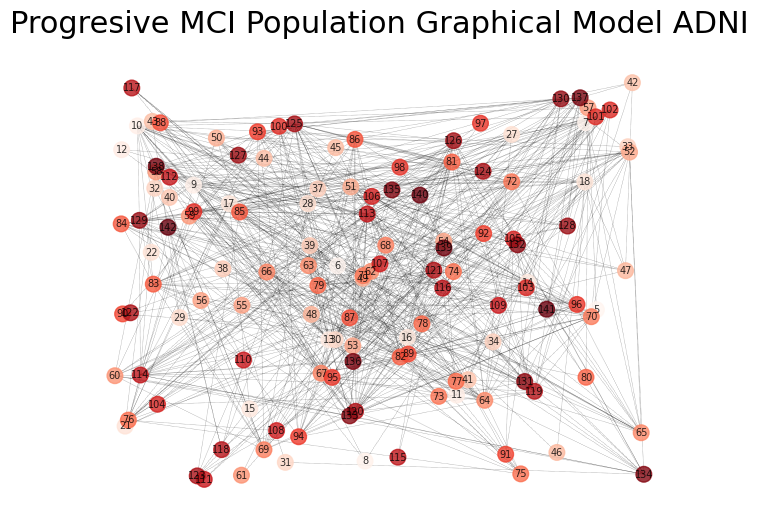

In [21]:
#edges represents conditional independence structure of data, strength and direction of a relationship between 
#this graph has learned and pruned the weaker connections in the precision matrix
#graph represents the strongest and most important connections between the brain volume 

precision_matrix_p = model.precision_
np.fill_diagonal(precision_matrix_p, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_prog = nx.Graph(precision_matrix_p)
#create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(progs_norm.columns)}

#relabel the nodes in the graph using the dictionary
G_prog = nx.relabel_nodes(G_prog, node_labels)

#visualize the relabeled graph
pos = nx.random_layout(G_prog)
nx.draw(G_prog, pos, with_labels=True, font_size=7, style="dotted",
        node_color=range(len(G_prog)), cmap=plt.cm.Reds,
        node_size=150*len(G_prog)/154, alpha=.8, width=.3)
plt.title("Progresive MCI Population Graphical Model ADNI", fontsize=22)
plt.show()

In [22]:
#strongest edges sorted 
#the numbers are region ids which you can find in the neuromorphometrics.csv
edges_sorted = sorted(G_prog.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(int(edge[0]), int(edge[1]), edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(18, 78, {'weight': 0.265287058722154})
(39, 66, {'weight': 0.21076456458218498})
(17, 29, {'weight': 0.20689720461596908})
(18, 30, {'weight': 0.19507026389440646})
(18, 28, {'weight': 0.18189769608126097})
(18, 48, {'weight': 0.16901224609150184})
(12, 18, {'weight': 0.15891263980248355})
(17, 77, {'weight': 0.13193825494142825})
(17, 27, {'weight': 0.1287118018191243})
(18, 110, {'weight': 0.12369262966687461})


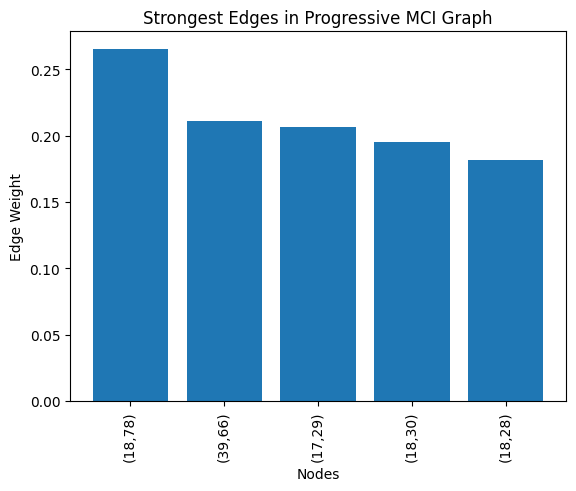

In [23]:
#plot 
top_edges = edges_sorted_shifted[:5]
x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Progressive MCI Graph')
plt.show()

In [25]:
#transpose stable 
stable_norm = stable_norm.T
print(stable_norm.shape)  #shape needs to be 390 x 140 patients x regions 

(390, 130)


In [26]:
#fit for stable df 
stab_model = GraphicalLassoCV(cv=5)
stab_model.fit(stable_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5)

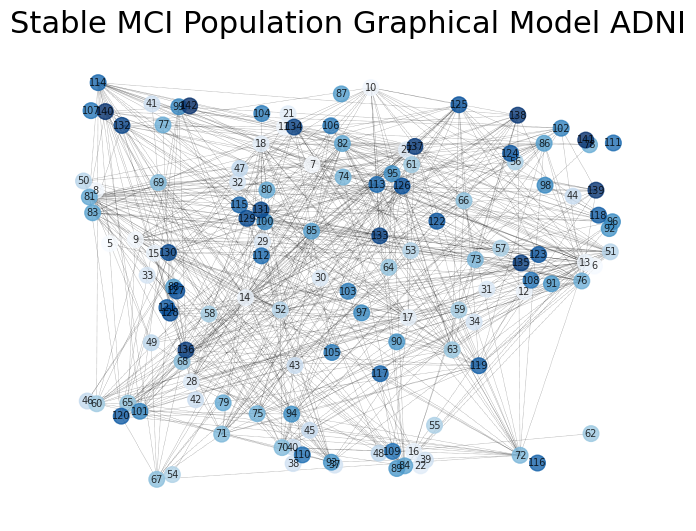

In [28]:
precision_matrix_s = stab_model.precision_
np.fill_diagonal(precision_matrix_s, 0) #removes self connections by replacing the diagnonal of matrix with 0 

G_stab = nx.Graph(precision_matrix_s)
#create a dictionary that maps old node labels to new node labels
node_labels = {i: label for i, label in enumerate(stable_norm.columns)}

#relabel the nodes in the graph using the dictionary
G_stab = nx.relabel_nodes(G_stab, node_labels)

#visualize the relabeled graph
pos = nx.random_layout(G_stab)
nx.draw(G_stab, pos, with_labels=True, font_size=7, style="dotted",
        node_color=range(len(G_stab)), cmap=plt.cm.Blues,
        node_size=150*len(G_stab)/154, alpha=.8, width=.3)
plt.title("Stable MCI Population Graphical Model ADNI", fontsize=22)
plt.show()

In [29]:
#strongest 10 edges 
edges_sorted = sorted(G_stab.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(int(edge[0]), int(edge[1]), edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(18, 78, {'weight': 0.27783956633253576})
(17, 77, {'weight': 0.2586528197553451})
(17, 29, {'weight': 0.21298144204037386})
(17, 103, {'weight': 0.16973816862326385})
(17, 27, {'weight': 0.15968144723422525})
(18, 30, {'weight': 0.1437351771043876})
(17, 28, {'weight': 0.13042776487967941})
(17, 47, {'weight': 0.12334081201739118})
(18, 48, {'weight': 0.1228802172175597})
(18, 46, {'weight': 0.1227428875966686})


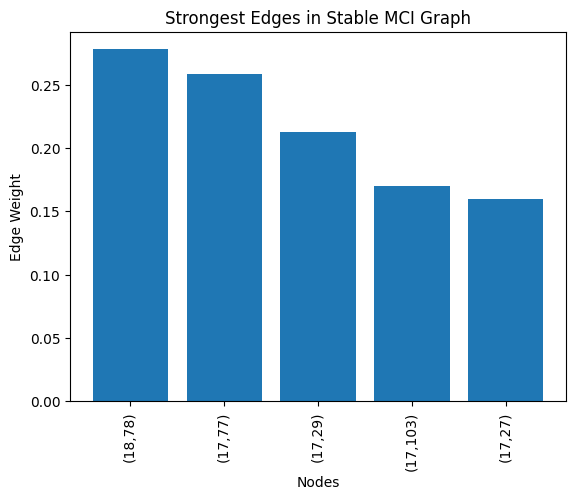

In [30]:
#plot 
top_edges = edges_sorted_shifted[:5]

x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Stable MCI Graph')
plt.show()

In [36]:
#start with formattting data, getting master csv of all patients regional volume 
#create master csv file with all vol for each region for eahc patient
#cols would be 'id','001','002'....
#rows would be id numbers 0173

#fiugre out why this isnt working correctly 
#change this for NACC dataset

dir_n = "/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi"
data_dic_n = {}
patient_data_n = {}
#iterate through patient folders to extract the values of the .npy files 
#need touble check this by printing id because NACC folders have naming convention NACC[0-9][0-9][0-9][0-9][0-9][0-9]
for folder in sorted(glob.glob(os.path.join(dir_n,"NACC*"))):
    # print(f"processing: {folder}")
    id = folder[-6:]

    # print(id)
    volumes = []
    #data dicitonary to store corresponding labels and values 
    for file in sorted(glob.glob(os.path.join(folder, "*.npy"))): #search for all .npy files 
        reg_num = os.path.splitext(os.path.basename(file))[0] #os.path.basename returns filename itself with extension
        #os.path.splittext()[0] splits file basename into a tuple of file name string and the extension (001,.npy) [0] tells it to extract first el of this tuple (001)
        # print(reg_num)
        node_data = np.load(file)
        # print(reg_num, node_data)
        data_dic_n[reg_num]=node_data
        volumes.append(node_data)

    patient_data_n[id]=volumes

patient_ids = list(patient_data_n.keys())

df_n = pd.DataFrame.from_dict(patient_data_n,orient='index')
df_n.columns = [str(int(col) + 1) for col in df_n.columns]
df_n['RID'] = patient_ids
#only pad ids that are not already 6 digits 
df_n['RID']=df_n['RID'].apply(lambda x: f"NACC{x:0>6}")
#make rid col the index (first col)
df_n = df_n.set_index('RID').reset_index()


#adding a weird last row to the df with empty values so drop is 
df_n = df_n.drop(df_n.index[-1],axis=0)
#save
df_n.to_csv('/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/mega_NACC.csv')

In [41]:
#add in progression info and then split dataframes into stable and progressive mci 
#find nacc prog info 

prog_info_n = pd.read_csv("/data2/MRI_PET_DATA/graph/csvs/NACC_surv_prog.csv")

prog_n = prog_info_n[['RID',"PROGRESSES"]]
#add in padded zeros to prog df 
prog_n['RID']=prog_n["RID"].astype(str).str.zfill(4)

prog_n = prog_n[prog_n["RID"].isin(df_n['RID'].astype(str))]

prog_n=prog_n.reset_index(drop=True)
# print(f"N Progressive MCI={prog['PROGRESSES'].value_counts()[1]}\nN Stable MCI={(545-154)}")  #in entire dataset, only 154 who progress 
print(f"N Progressive MCI={prog_n['PROGRESSES'].value_counts()[1]}\nN Stable MCI = {(508-130)}")

#merge all_df df and prog df on index RID and ID
merged = pd.merge(prog_n,df_n,on='RID')


N Progressive MCI=130
N Stable MCI = 378


/tmp/ipykernel_1952981/2224490863.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_n['RID']=prog_n["RID"].astype(str).str.zfill(4)


In [42]:
#separate dfs for progressors and stable 
#creat empty dfs 
n_progs = pd.DataFrame()
n_stable = pd.DataFrame()

for index,row in merged.iterrows():
    if row['PROGRESSES']==1:
        n_progs = n_progs.append(row)
    else:
        n_stable = n_stable.append(row)

# print(progs)
# print(stable)

n_progs.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_vol.csv")
n_stable.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_vol.csv")

In [43]:
#drop row 23 and 25 because they are ventricle and chiasm and have no volume 
# zero_col = df.columns[(df ==0).any()]
# print(zero_col)

#drop 1,2,3,4,23,24,25,26,35,36

n_progs = n_progs.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)
n_stable = n_stable.drop(['1','2','3','4','23','24','25','26','35','36'], axis =1)

#drop all the ventricles and region 001 because its the background and not the data we need 
#in this the bacground region 0 and region 1 are both combined in region 1 
n_progs.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_progressors_pruned_vol.csv")
n_stable.to_csv("/data2/MRI_PET_DATA/graph/NACC/Morph/mri_atlas/morph/roi/NACC_stable_pruned_vol.csv")

In [44]:
#for the correlation matrix need to only have the values 
n_progs = n_progs.drop(["RID","PROGRESSES"], axis =1)
n_stable = n_stable.drop(["RID","PROGRESSES"], axis =1)

#convert to float
n_progs = n_progs.astype(float)
n_stable = n_stable.astype(float)
# print(stable)

In [45]:
#normalize with z score, negative values are fine it means its an std below mean 
n_progs_norm = (n_progs - n_progs.mean()) / n_progs.std()
n_stable_norm = (n_stable - n_stable.mean()) / n_stable.std()
# print(progs_norm)

In [47]:
#NEEDS TO BE 130x 132 format for model  (132 brain regions left)
n_progs_norm = n_progs_norm.T
print(n_progs_norm.shape)

(130, 132)


In [56]:
model = GraphicalLassoCV(cv=5) #cv=5 specifies 5-fold cross validation strategy to optimize model hyperparameters 
model.fit(n_progs_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


GraphicalLassoCV(cv=5)

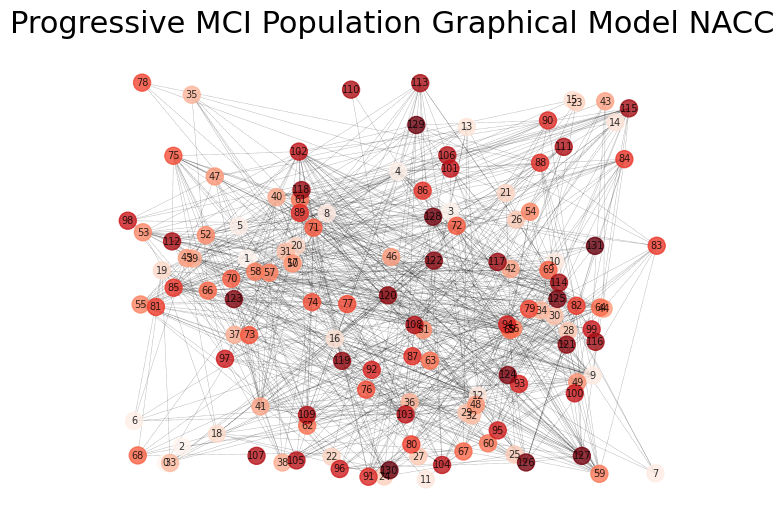

In [72]:
#construct gaussian graphican model for NACC progressive MCI 
precision_matrix_np = model.precision_
np.fill_diagonal(precision_matrix_np, 0)
G_n_prog = nx.Graph(precision_matrix_np)
pos = nx.random_layout(G_n_prog)
nx.draw(G_n_prog, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_np)),
        cmap=plt.cm.Reds, node_size=150*len(precision_matrix_np)/132, alpha=.8, width=.3)
#size inconsistent and makes me enter 
plt.title("Progressive MCI Population Graphical Model NACC", fontsize=22)
plt.show()

In [58]:
#strongest edges 
edges_sorted = sorted(G_n_prog.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(8, 14, {'weight': 0.8081280916439814})
(14, 52, {'weight': 0.5846940558012397})
(8, 22, {'weight': 0.5420483736426855})
(14, 38, {'weight': 0.3971330780432793})
(22, 52, {'weight': 0.26123246493864094})
(13, 21, {'weight': 0.25501459715961994})
(13, 67, {'weight': 0.24904302557367547})
(46, 102, {'weight': 0.23550528347468172})
(22, 46, {'weight': 0.2040683771810523})
(13, 19, {'weight': 0.18903509139145883})


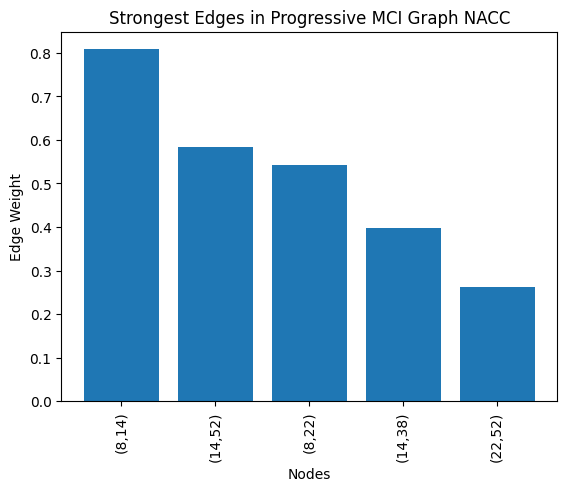

In [59]:
#plot 
top_edges = edges_sorted_shifted[:5]

x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Progressive MCI Graph NACC')
plt.show()

In [75]:
#stable model and graph 
#NEEDS TO BE 378x 132 format for model  (32 brain regions left)
n_stable_norm = n_stable_norm.T
print(n_stable_norm.shape)

(378, 132)


In [76]:
#stable model 
#fit for stable norm df 
n_stab_model = GraphicalLassoCV(cv=5)
n_stab_model.fit(n_stable_norm)

/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/data2/MRI_PET_DATA/graph/graph_env/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:297: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 9.153e-04
  warnings.warn(


GraphicalLassoCV(cv=5)

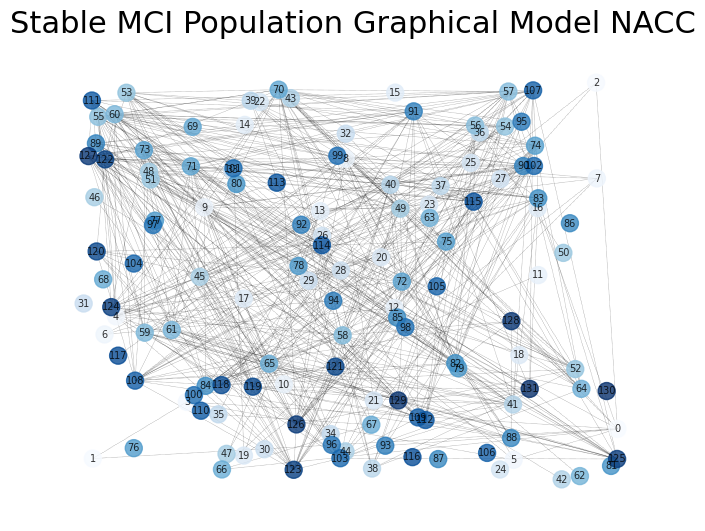

In [78]:
#stable graph 
precision_matrix_ns = n_stab_model.precision_
np.fill_diagonal(precision_matrix_ns, 0)
G_n_stab = nx.Graph(precision_matrix_ns)
pos = nx.random_layout(G_n_stab)
nx.draw(G_n_stab, pos,with_labels=True, font_size=7, style="dotted", node_color=range(len(precision_matrix_ns)),
        cmap=plt.cm.Blues, node_size=150*len(precision_matrix_ns)/132, alpha=.8, width=.3)
plt.title("Stable MCI Population Graphical Model NACC", fontsize=22)
plt.show()

In [79]:
#top 10 strongest edges in stable 
edges_sorted = sorted(G_n_stab.edges(data=True),key=lambda x: x[2]['weight'],reverse=True)
edges_sorted_shifted = [(edge[0]+1, edge[1]+1, edge[2]) for edge in edges_sorted]
for edge in edges_sorted_shifted[:10]:
        print(edge)

(8, 22, {'weight': 0.6654628847341104})
(8, 100, {'weight': 0.590366683206648})
(13, 21, {'weight': 0.3298110262672875})
(46, 100, {'weight': 0.26497414450752155})
(8, 14, {'weight': 0.2558890942096627})
(14, 68, {'weight': 0.24919727692235774})
(13, 67, {'weight': 0.20745862879657145})
(14, 38, {'weight': 0.12752115284126436})
(22, 46, {'weight': 0.12064692506015218})
(7, 13, {'weight': 0.12007050173735036})


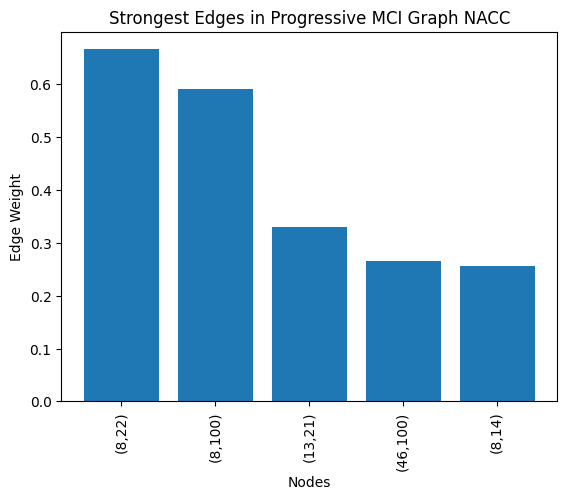

In [80]:
#plot top edges 
#plot 
top_edges = edges_sorted_shifted[:5]

x_values = [f"({edge[0]},{edge[1]})" for edge in edges_sorted_shifted[:5]]
y_values = [edge[2]['weight'] for edge in edges_sorted_shifted[:5]]

plt.bar(x_values, y_values)
plt.xticks(rotation=90)
plt.xlabel('Nodes')
plt.ylabel('Edge Weight')
plt.title('Strongest Edges in Progressive MCI Graph NACC')
plt.show()